In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

In [2]:
root_url = 'https://serebii.net/pokedex/'

In [3]:
page_urls = []
for num in range(1,152):
    if num < 10:
        page_urls.append(root_url+'00'+str(num)+'.shtml')
    elif num < 100:
        page_urls.append(root_url+'0'+str(num)+'.shtml')
    else:
        page_urls.append(root_url+str(num)+'.shtml')

In [4]:
print(page_urls)

['https://serebii.net/pokedex/001.shtml', 'https://serebii.net/pokedex/002.shtml', 'https://serebii.net/pokedex/003.shtml', 'https://serebii.net/pokedex/004.shtml', 'https://serebii.net/pokedex/005.shtml', 'https://serebii.net/pokedex/006.shtml', 'https://serebii.net/pokedex/007.shtml', 'https://serebii.net/pokedex/008.shtml', 'https://serebii.net/pokedex/009.shtml', 'https://serebii.net/pokedex/010.shtml', 'https://serebii.net/pokedex/011.shtml', 'https://serebii.net/pokedex/012.shtml', 'https://serebii.net/pokedex/013.shtml', 'https://serebii.net/pokedex/014.shtml', 'https://serebii.net/pokedex/015.shtml', 'https://serebii.net/pokedex/016.shtml', 'https://serebii.net/pokedex/017.shtml', 'https://serebii.net/pokedex/018.shtml', 'https://serebii.net/pokedex/019.shtml', 'https://serebii.net/pokedex/020.shtml', 'https://serebii.net/pokedex/021.shtml', 'https://serebii.net/pokedex/022.shtml', 'https://serebii.net/pokedex/023.shtml', 'https://serebii.net/pokedex/024.shtml', 'https://serebi

In [13]:
def scrape_data(page_urls):
    pokemon_data = {'number':[],'name':[],'type1':[],'type2':[],'species':[],
                    'hp':[],'attack':[],'defense':[],'special':[],'speed':[],
                    'base_stat_total':[],'exp':[],'growth_rate':[]}
    for url in page_urls:
        try:
            res = requests.get(url)
            res.raise_for_status()
        except requests.exceptions.HTTPError as err:
            raise SystemExit(err)
        soup = BeautifulSoup(res.text, 'html.parser')
        tables = soup.select('td[class=fooinfo]')
        page_text = [table.getText() for table in tables]
        cleaner_text = [re.split(r'\n+|\r+|\t+', element) for element in page_text]
        pokemon_data['number'].append(cleaner_text[3][0])
        pokemon_data['name'].append(cleaner_text[1][0])
        pokemon_data['species'].append(cleaner_text[4][0])
        base_stats = re.findall(r'\d+',cleaner_text[9][0])
        base_stats = [int(stat) for stat in base_stats]
        pokemon_data['hp'].append(base_stats[0])
        pokemon_data['attack'].append(base_stats[1])
        pokemon_data['defense'].append(base_stats[2])
        pokemon_data['special'].append(base_stats[3])
        pokemon_data['speed'].append(base_stats[4])
        pokemon_data['base_stat_total'].append(sum(base_stats))
        exp_growth_rate = re.findall(r'(\d+,\d+,\d+)\sPoints(.+)$',cleaner_text[8][0])
        if exp_growth_rate:
            pokemon_data['exp'].append(exp_growth_rate[0][0])
            pokemon_data['growth_rate'].append(exp_growth_rate[0][1])
        else:
            pokemon_data['exp'].append(None)
            pokemon_data['growth_rate'].append(None)
        images = soup.findAll('img')
        img_srcs = [image['src'] for image in images]
        pokemon_data['type1'].append(re.findall(r'(\w+)\.gif',img_srcs[9])[0])
        type2 = re.findall(r'(\w+)\.gif',img_srcs[10])[0]
        if type2 == 'normal2':
            type2 = None
        pokemon_data['type2'].append(type2)
        pokemon_dataframe = pd.DataFrame(pokemon_data)
    return pokemon_dataframe

In [14]:
pokemon_dataframe = scrape_data(page_urls)

In [15]:
pokemon_dataframe.head()

,number,name,type1,type2,species,hp,attack,defense,special,speed,base_stat_total,exp,growth_rate
0,#001,Bulbasaur,grass,poison,Seed Pokémon,45,49,49,65,45,253,"1,059,860",Medium Slow
1,#002,Ivysaur,grass,poison,Seed Pokémon,60,62,63,80,60,325,"1,059,860",Medium Slow
2,#003,Venusaur,grass,poison,Seed Pokémon,80,82,83,100,80,425,"1,059,860",Medium Slow
3,#004,Charmander,fire,None,Lizard Pokémon,39,52,43,50,65,249,"1,059,860",Medium Slow
4,#005,Charmeleon,fire,None,Flame Pokémon,58,64,58,65,80,325,"1,059,860",Medium Slow


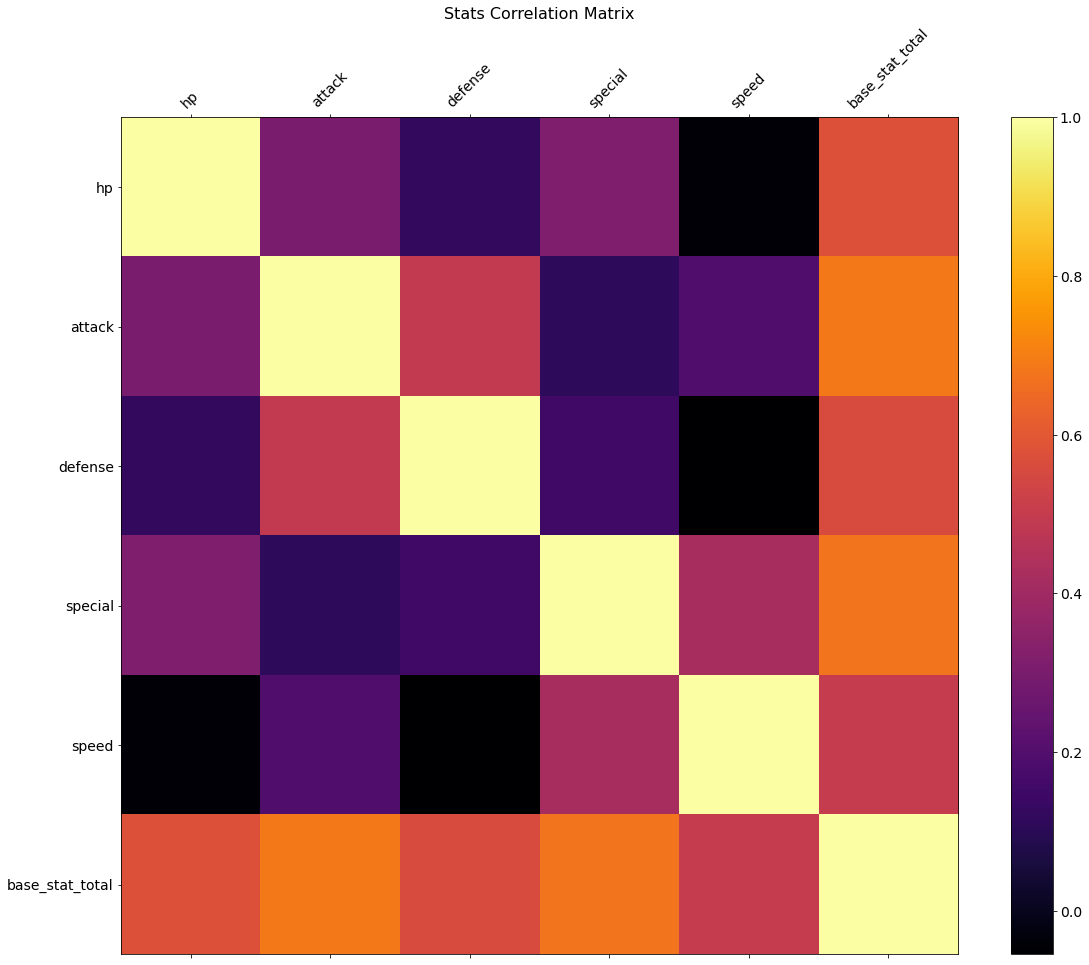

In [34]:
import matplotlib.pyplot as plt
df = pokemon_dataframe
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number, cmap='inferno')
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Stats Correlation Matrix', fontsize=16);